In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_curve, roc_auc_score, confusion_matrix
from sklearn.cluster import KMeans
from sklearn.model_selection import KFold
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import random
import math # cos() for Rastrigin
import copy # array-copying convenience
import sys # max float
import pandas as pd
from scipy import stats

In [ ]:
dt=pd.read_csv('/content/heart_statlog_cleveland_hungary_final.csv')

In [ ]:
# renaming
dt.columns = ['age', 'sex', 'chest_pain_type', 'resting_blood_pressure', 'cholesterol', 'fasting_blood_sugar', 'rest_ecg', 'max_heart_rate_achieved',
       'exercise_induced_angina', 'st_depression', 'st_slope','target']

In [ ]:
dt['chest_pain_type'][dt['chest_pain_type'] == 1] = 'typical angina'
dt['chest_pain_type'][dt['chest_pain_type'] == 2] = 'atypical angina'
dt['chest_pain_type'][dt['chest_pain_type'] == 3] = 'non-anginal pain'
dt['chest_pain_type'][dt['chest_pain_type'] == 4] = 'asymptomatic'



dt['rest_ecg'][dt['rest_ecg'] == 0] = 'normal'
dt['rest_ecg'][dt['rest_ecg'] == 1] = 'ST-T wave abnormality'
dt['rest_ecg'][dt['rest_ecg'] == 2] = 'left ventricular hypertrophy'


dt['st_slope'][dt['st_slope'] == 1] = 'upsloping'
dt['st_slope'][dt['st_slope'] == 2] = 'flat'
dt['st_slope'][dt['st_slope'] == 3] = 'downsloping'

dt["sex"] = dt.sex.apply(lambda  x:'male' if x==1 else 'female')

<ipython-input-4-b11fb82ceb67>:1: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  dt['chest_pain_type'][dt['chest_pain_type'] == 1] = 'typical angina'
<ipython-input-4-b11fb82ceb67>:1: SettingWithCopyWarning: 
A value is trying to be set on a 

In [ ]:
#removing row with st_slope =0
dt.drop(dt[dt.st_slope == 0].index, inplace=True)

#checking distribution
dt['st_slope'].value_counts()

,count
st_slope,
flat,582
upsloping,526
downsloping,81


In [ ]:
# filtering numeric features as age , resting bp, cholestrol and max heart rate achieved has outliers as per EDA

dt_numeric = dt[['age','resting_blood_pressure','cholesterol','max_heart_rate_achieved']]

In [ ]:
# calculating zscore of numeric columns in the dataset
z = np.abs(stats.zscore(dt_numeric))
print(z)

           age  resting_blood_pressure  cholesterol  max_heart_rate_achieved
0     1.466266                0.428136     0.775228                 1.264301
1     0.503599                1.517370     0.299516                 0.637259
2     1.787155                0.116481     0.716067                 1.635766
3     0.610562                0.319212     0.035725                 1.243865
4     0.031216                0.972753     0.151616                 0.695204
...        ...                     ...          ...                      ...
1185  0.931451                1.205715     0.528727                 0.303303
1186  1.528698                0.645983     0.171336                 0.049408
1187  0.352105                0.116481     0.782658                 0.969535
1188  0.352105                0.116481     0.252646                 1.342681
1189  1.680192                0.319212     0.348816                 1.303491

[1189 rows x 4 columns]


In [ ]:
# Defining threshold for filtering outliers
threshold = 3
print(np.where(z > 3))

(array([  30,   76,  109,  149,  242,  366,  371,  391,  400,  450,  592,
        617,  733,  760, 1012, 1038, 1074]), array([2, 2, 1, 2, 1, 1, 3, 3, 1, 1, 1, 2, 1, 1, 1, 2, 1]))


In [ ]:
#filtering outliers retaining only those data points which are below threshhold
dt = dt[(z < 3).all(axis=1)]

In [ ]:
## encoding categorical variables
dt = pd.get_dummies(dt, drop_first=True)

dt.head()

,age,resting_blood_pressure,cholesterol,fasting_blood_sugar,max_heart_rate_achieved,exercise_induced_angina,st_depression,target,sex_male,chest_pain_type_atypical angina,chest_pain_type_non-anginal pain,chest_pain_type_typical angina,rest_ecg_left ventricular hypertrophy,rest_ecg_normal,st_slope_flat,st_slope_upsloping
0,40,140,289,0,172,0,0.0,0,True,True,False,False,False,True,False,True
1,49,160,180,0,156,0,1.0,1,False,False,True,False,False,True,True,False
2,37,130,283,0,98,0,0.0,0,True,True,False,False,False,False,False,True
3,48,138,214,0,108,1,1.5,1,False,False,False,False,False,True,True,False
4,54,150,195,0,122,0,0.0,0,True,False,True,False,False,True,False,True


In [ ]:
X=dt.iloc[:12,:]
y=dt.iloc[12,:]

X = dt.drop('target', axis=1) # all rows, and all columns except 'target'
y = dt['target'] # the target column

In [ ]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler(feature_range=(-1, 1))
X = scaler.fit_transform(X)

In [ ]:
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
def svm_score(position):
  #print("function access\n")
  fitness_value=0.0
  C = position[0]
  gamma = position[1]
  selected_indices = [i for i, include_feature in enumerate(position[2:]) if include_feature == 1]
  #print(position)
  #print("selected_indices = ",selected_indices)
  if(len(selected_indices) == 0):
    return 0
  X_selected_train = x_train[:, selected_indices]
  svm_model = SVC(C=C, gamma = gamma)
  svm_model.fit(X_selected_train, y_train)
  y_pred_score = svm_model.predict(X_selected_train)
  score = accuracy_score(y_train, y_pred_score)
  return score


In [ ]:
from sklearn.ensemble import StackingClassifier, ExtraTreesClassifier, RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
from sklearn.linear_model import LogisticRegression  # Meta-model for stacking

def ensemble_score(position):
    fitness_value = 0.0
    C = position[0]
    gamma = position[1]
    selected_indices = [i for i, include_feature in enumerate(position[2:]) if include_feature == 1]

    if len(selected_indices) == 0:
        return 0

    # Select the relevant features from the training and testing data
    X_selected_train = x_train[:, selected_indices]
    X_selected_test = x_test[:, selected_indices]

    # Define individual models for stacking
    svm_model = SVC(C=C, gamma=gamma)
    extra_trees = ExtraTreesClassifier(n_estimators=100,n_jobs=-1)

    # Two Random Forest classifiers with different criteria
    """
    random_forest_gini = RandomForestClassifier(n_estimators=100, criterion='gini',n_jobs=-1)
    random_forest_entropy = RandomForestClassifier(n_estimators=100, criterion='entropy',n_jobs=-1)

    adaboost = AdaBoostClassifier(n_estimators=50)
    decision_tree = DecisionTreeClassifier()
    gradient_boosting = GradientBoostingClassifier(n_estimators=100)"""

    # Define the stacking model with a LogisticRegression meta-model
    base_learners = [
        ('svm', svm_model),
        ('extra_trees', extra_trees),
    ]

    # Use Logistic Regression as a meta-model
    stacking_model = StackingClassifier(estimators=base_learners, final_estimator=LogisticRegression())

    # Train the stacking model
    stacking_model.fit(X_selected_train, y_train)

    # Make predictions
    y_pred_score = stacking_model.predict(X_selected_test)

    # Calculate the accuracy score
    score = accuracy_score(y_test, y_pred_score)
    return score



In [ ]:
# whale class ( class Variables: rnd, position of the solution, fitness of the solution)
class whale:
	def __init__(self, fitness, dim, minx, maxx, minh, maxh, seed):
		self.rnd = random.Random(seed)
		self.fitness_function = fitness
		self.position = [0.0 for i in range(dim)] # all zeros.
		self.d_whale = [0.0 for i in range(dim)] # deciding whale
		self.label = None
		self.positions_history = []  # list to store positions at each iteration
		self.fitness_history = []

		for i in range(2, dim):
			self.position[i] = ((maxx - minx) * self.rnd.random() + minx) # setting a random position value between the given interval ( x_min, x_max ).

		for i in range(2):
			self.position[i] = ((maxh - minh) * self.rnd.random() + minh) # setting a random position value between the given interval ( x_min, x_max ).

		self.fitness = fitness(self.position) # curr fitness




	def update_position_history(self):
		self.positions_history.append(copy.copy(self.position))
		self.fitness = self.fitness_function(self.position)
		self.fitness_history.append(copy.copy(self.fitness))

	def encoding_function(self):
		threshold = 0.4
		for i in range(2, len(self.position)):
			func_val = 1/(1 + math.exp(-self.position[i]))
			if (func_val <= threshold):
				self.position[i]=0
			else:
				self.position[i]=1

In [ ]:
def kmeans_clustering(whalePopulation, k):
    positions = [whale.position for whale in whalePopulation]

    kmeans = KMeans(n_clusters=k, random_state=0, n_init = 'auto').fit(positions)
    labels = kmeans.labels_

    clusters = [[] for _ in range(k)]

    for i, whale in enumerate(whalePopulation):
        cluster_id = labels[i]
        whale.label = cluster_id  # Assign the cluster label to the whale
        clusters[cluster_id].append(whale)

    return clusters


In [ ]:
def iterative_print_function(Iter, iter_Fbest, iter_Xbest, n_whales, whalePopulation, dim):
    if Iter % 10 == 0 :
        print("Iter = " + str(Iter) + " best fitness = %.3f" % iter_Fbest)
        print(" C = ", iter_Xbest[0], " Gamma = ", iter_Xbest[1])
        print("Feature Subset = [", end=" ")
        for _ in range(dim):
            print(iter_Xbest[_], end=",")
        print("]", end="\n")
        for i in range(n_whales):
            print("whale",i,end=" ")
            print("cluster",whalePopulation[i].label, end=" ")
            print("position: [[", end=" ")
            for _ in range(dim):
                print(whalePopulation[i].position[_], end=",")
            print("]]", end=" ")
            print("--> d_whale: [", end=" ")
            for _ in range(dim):
                print(whalePopulation[i].d_whale[_], end=",")
            print("]", end=" ")
            print(" ---> Accuracy: (",whalePopulation[i].fitness,")")

        print("-----------------------------")

In [ ]:
def plot_whale_positions(whalePopulation, iteration):
    fig, ax = plt.subplots()

    for whale in whalePopulation:
        if iteration >= len(whale.positions_history):
            continue

        position = whale.positions_history[iteration]
        cluster = whale.label
        color = 'C{}'.format(cluster)

        ax.scatter(position[0], position[1], color=color, label=f'Cluster {cluster}')

    ax.set_xlabel('C')
    ax.set_ylabel('Gamma')
    ax.set_title('Whale Positions')
    plt.show()

In [ ]:
def plot_3d_path(whale):
    positions = whale.positions_history
    accuracy = whale.fitness_history

    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')

    for i in range(len(positions)):
        x = positions[i][0]
        y = positions[i][1]
        z = accuracy[i]

        ax.scatter(x, y, z, c=i, cmap='viridis')

        if i > 0:  # Skip the first point since there's no previous point to connect with
            x_prev = positions[i - 1][0]
            y_prev = positions[i - 1][1]
            z_prev = accuracy[i - 1]

            ax.plot([x_prev, x], [y_prev, y], [z_prev, z], color='gray', linestyle='dotted')

    ax.set_xlabel('C')
    ax.set_ylabel('Gamma')
    ax.set_zlabel('Accuracy')
    ax.set_title('Path of the whale after optimization')

    plt.show()


In [ ]:


# whale optimization algorithm(WOA)
def woa(fitness, max_iter, n_whales, dim, minx, maxx, minh, maxh, k, kmeans_var_max, plot_iter, best_position_info):
    rnd = random.Random(0)

    # initialize n_whales random whales with given fitness function, maximum iterations, dimensions, upper bound and lower bound of x
    # and seed running from 0 to n_whales-1.
    whalePopulation = [whale(fitness, dim, minx, maxx, minh, maxh, i) for i in range(n_whales)]

    # compute the value of best_position and best_fitness in the whale Population
    # i.e initialize the X_best as all zeros [0, 0, 0,....p times].
    # init as INT_MAX (minimization problem).


    # main loop of woa
    Iter = 0
    kmeans_var = kmeans_var_max

    global_Xbest = [0.0 for i in range(dim)]
    global_Fbest = sys.float_info.min


    while Iter < max_iter:



        # Encoding the positions of the whales
        for i in range(n_whales):
            whalePopulation[i].encoding_function()


        ###################### CLUSTERING CALL MODULE #################################

        if(kmeans_var == kmeans_var_max):
            kmeans_clustering(whalePopulation, k)
            print("\n\n\n K MEANS CLUSTERING \n\n\n")
            kmeans_var = 0

        ###############################################################################


        iter_Xbest = [0.0 for i in range(dim)]
        iter_Fbest = sys.float_info.min
        iter_Xbest_num = 0
        iter_Xbest_label = 0
        #Finding global best
        for i in range(n_whales):
            if (whalePopulation[i].fitness > iter_Fbest):
                iter_Fbest = whalePopulation[i].fitness
                iter_Xbest = copy.copy(whalePopulation[i].position)
                iter_Xbest_num = i
                iter_Xbest_label = whalePopulation[i].label

        if (iter_Fbest > global_Fbest):
            global_Fbest = iter_Fbest
            global_Xbest = copy.copy(iter_Xbest)
            best_position_info[0] = iter_Xbest_num
            best_position_info[1] = iter_Xbest_label
            best_position_info[2] = Iter
            best_position_info[3] = global_Fbest




        # after every 10 iterations
        # print iteration number and best fitness value so far
        iterative_print_function(Iter, iter_Fbest, iter_Xbest, n_whales, whalePopulation, dim)


        # linearly decreased from 2 to 0
        a = 2 * (1 - Iter / max_iter)
        a2 = -1 + Iter * ((-1) / max_iter)


        if(Iter == max_iter):
            break

        ################################### MOVEMENT MODULE ###########################################################

        for i in range(n_whales):




            Xbest = [0.0 for i in range(dim)]
            Fbest = sys.float_info.min

            # replacing Fbest and Xbest if better fitness (lesser value of fitness function) is obtained.
            for j in range(n_whales):  # check each whale
                if ((whalePopulation[j].fitness > Fbest) and (whalePopulation[i].label == whalePopulation[j].label)) :
                    Fbest = whalePopulation[j].fitness
                    Xbest = copy.copy(whalePopulation[j].position)


            A = 2 * a * rnd.random() - a
            C = 2 * rnd.random()
            b = 1
            l = (a2 - 1) * rnd.random() + 1
            p = rnd.random()

            D = [0.0 for i in range(dim)]
            D1 = [0.0 for i in range(dim)]
            Xnew = [0.0 for i in range(dim)]
            Xrand = [0.0 for i in range(dim)]

            # CIRCULAR MOTION for p < 0.5.
            if p < 0.5:

                # Shrinking Net for p < 0.5 and |A| < 1.
                if abs(A) < 1:
                    for j in range(dim):
                        D[j] = abs(C * Xbest[j] - whalePopulation[i].position[j])
                        Xnew[j] = Xbest[j] - A * D[j]
                        whalePopulation[i].d_whale[j] = copy.copy(Xbest[j])

                # Exploration based on Random reference for p < 0.5 and |A| > 1.
                else:
                    p = random.randint(0, n_whales - 1)
                    while p == i:
                        p = random.randint(0, n_whales - 1)

                    Xrand = whalePopulation[p].position

                    for j in range(dim):
                        D[j] = abs(C * Xrand[j] - whalePopulation[i].position[j])
                        Xnew[j] = Xrand[j] - A * D[j]
                        whalePopulation[i].d_whale[j] = copy.copy(Xrand[j])

            # HELICAL MOTION for p > 0.5.
            else:
                for j in range(dim):
                    D1[j] = abs(Xbest[j] - whalePopulation[i].position[j])
                    Xnew[j] = D1[j] * math.exp(b * l) * math.cos(2 * math.pi * l) + Xbest[j]
                    whalePopulation[i].d_whale[j] = copy.copy(Xbest[j])

            for j in range(dim):
                whalePopulation[i].position[j] = Xnew[j]




        ######################### CLIPPING MODULE #####################################################

        for i in range(n_whales):
            # if Xnew < minx OR Xnew > maxx
            # then clip it
            for j in range(2):
                whalePopulation[i].position[j] = max(whalePopulation[i].position[j], minh)
                whalePopulation[i].position[j] = min(whalePopulation[i].position[j], maxh)
            for j in range(2, dim):
                whalePopulation[i].position[j] = max(whalePopulation[i].position[j], minx)
                whalePopulation[i].position[j] = min(whalePopulation[i].position[j], maxx)

            whalePopulation[i].update_position_history()  # store current position in history
        ##############################################################################################


        Iter += 1
        kmeans_var += 1
    # end-while



    #plotting the path
    plot_whale_positions(whalePopulation, plot_iter)
    plot_3d_path(whalePopulation[0])
    # returning the best solution
    return global_Xbest


# ----------------------------


In [ ]:
def best_pos_predict():
    print("\nBegin whale optimization algorithm on support vector machines\n")
    dim = len(X[0]) + 2

    fitness = ensemble_score

    num_whales = 15

    max_iter = 20

    minx = -1.0

    maxx = 1.0

    minh = 0.01

    maxh = 1.0

    k = 7

    kmeans_var_max = 10

    plot_iter = 10

    best_position_info = [0.0 for i in range(4)]

    best_position = woa(fitness, max_iter, num_whales, dim, minx, maxx, minh, maxh, k, kmeans_var_max, plot_iter, best_position_info)
    print("Best Position: ", best_position)
    print("Best Position Info: ", best_position_info)
    return best_position

In [ ]:
"""dim = len(X[0]) + 2
def optimized_pred():
    print("op")
    best_position = best_pos_predict()
    C = best_position[0]
    gamma = best_position[1]
    print("C value:", best_position[0])
    optimized_SVM = SVC(C=C, gamma=gamma, kernel='rbf')
    selected_indices_best = [i for i, include_feature in enumerate(best_position[2:]) if include_feature == 1]
    X_selected_train = x_train[:, selected_indices_best]
    X_selected_test = x_test[:, selected_indices_best]
    optimized_SVM.fit(X_selected_train, y_train)
    optimized_y_pred = optimized_SVM.predict (X_selected_test)
    final_score = accuracy_score(optimized_y_pred, y_test)
    print(" C = ", C, " Gamma = ", gamma)
    print("selected indices of best solution: ", selected_indices_best)
    print("Accuracy of the current Optimized Support Vector Machine: ", final_score)
    return final_score"""

dim=len(X[0])+2

def optimized_pred():
    print("op")
    # Retrieve best position (hyperparameters and feature selection)
    best_position = best_pos_predict()
    C = best_position[0]
    gamma = best_position[1]
    print("C value:", C)

    # Select features based on best_position
    selected_indices_best = [i for i, include_feature in enumerate(best_position[2:]) if include_feature == 1]
    X_selected_train = x_train[:, selected_indices_best]
    X_selected_test = x_test[:, selected_indices_best]

    # Define base models for the ensemble
    svm_model = SVC(C=C, gamma=gamma, kernel='rbf')
    extra_trees = ExtraTreesClassifier(n_estimators=100,n_jobs=-1)
    """
    random_forest_gini = RandomForestClassifier(n_estimators=100, criterion='gini',n_jobs=-1)
    random_forest_entropy = RandomForestClassifier(n_estimators=100, criterion='entropy',n_jobs=-1)
    adaboost = AdaBoostClassifier(n_estimators=50)
    decision_tree = DecisionTreeClassifier()
    gradient_boosting = GradientBoostingClassifier(n_estimators=100)"""

    # Define the stacking classifier with Logistic Regression as meta-model
    base_learners = [
        ('svm', svm_model),
        ('extra_trees', extra_trees),
    ]

    # Stacking classifier
    stacking_model = StackingClassifier(estimators=base_learners, final_estimator=LogisticRegression())

    # Train the stacking model
    stacking_model.fit(X_selected_train, y_train)

    # Make predictions
    optimized_y_pred = stacking_model.predict(X_selected_test)

    # Calculate accuracy
    final_score = accuracy_score(y_test, optimized_y_pred)

    # Print results
    print("C = ", C, " Gamma = ", gamma)
    print("selected indices of best solution: ", selected_indices_best)
    print("Accuracy of the current Optimized Stacking Model: ", final_score)

    return final_score



In [ ]:
def accuracy_plot(acc_list):
    x_values = list(range(len(acc_list)))

    # Create a line plot with dotted lines
    plt.plot(x_values, acc_list, marker='o', linestyle='dotted')

    # Adding labels and title
    plt.xlabel('kth cross validation')
    plt.ylabel('Accuracy')
    plt.title('Accuracy During Cross-Validation')

    # Show the plot
    plt.show()

In [ ]:
def k_fold_cv(k_cv):
    acc_list = []
    list_sum = 0.0
    for i in range(k_cv):
      print("kcv",i)
      ith_accuracy = optimized_pred()
      acc_list.append(copy.copy(ith_accuracy))
      list_sum = list_sum + ith_accuracy
    print("Accuracy list: ",acc_list )
    print("Accuracy after 10 fold cv: ", list_sum/k_cv)
    accuracy_plot(acc_list)
    return list_sum/k_cv


kcv 0
op

Begin whale optimization algorithm on support vector machines




 K MEANS CLUSTERING 



Iter = 0 best fitness = 0.000
 C =  0.0  Gamma =  0.0
Feature Subset = [ 0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,]
whale 0 cluster 6 position: [[ 0.2580012779488161,0.9106487934085578,1,1,1,0,1,1,1,1,1,1,1,1,0,1,1,]] --> d_whale: [ 0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,]  ---> Accuracy: ( 0 )
whale 1 cluster 5 position: [[ 0.7243246320173747,0.23647459905774812,0,1,1,0,1,1,1,1,0,0,1,1,1,0,1,]] --> d_whale: [ 0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,]  ---> Accuracy: ( 0 )
whale 2 cluster 6 position: [[ 0.9948713673202453,0.9499015183623112,1,1,0,0,1,1,1,1,1,1,1,0,1,1,1,]] --> d_whale: [ 0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,]  ---> Accuracy: ( 0 )
whale 3 cluster 5 position: [[ 0.1591102597832887,0.6385120517023366,0,1,1,1,1,0,0,1,0,0,1,1,1,1,1,]] --> d_whale: [ 0.0,0.0,0.0,

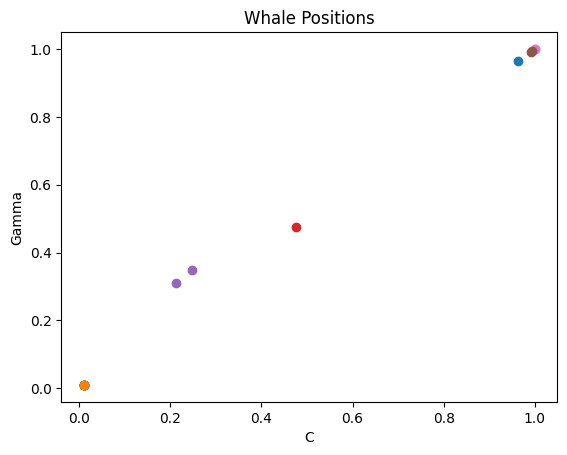

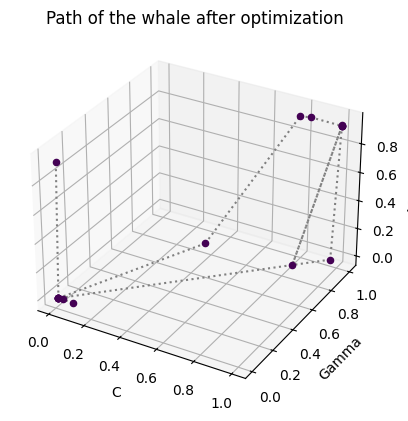

Best Position:  [0.025967664852196266, 0.025967664852196266, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
Best Position Info:  [1, 5, 3, 0.9531914893617022]
C value: 0.025967664852196266
C =  0.025967664852196266  Gamma =  0.025967664852196266
selected indices of best solution:  [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14]
Accuracy of the current Optimized Stacking Model:  0.9404255319148936
kcv 1
op

Begin whale optimization algorithm on support vector machines




 K MEANS CLUSTERING 



Iter = 0 best fitness = 0.000
 C =  0.0  Gamma =  0.0
Feature Subset = [ 0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,]
whale 0 cluster 6 position: [[ 0.2580012779488161,0.9106487934085578,1,1,1,0,1,1,1,1,1,1,1,1,0,1,1,]] --> d_whale: [ 0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,]  ---> Accuracy: ( 0 )
whale 1 cluster 5 position: [[ 0.7243246320173747,0.23647459905774812,0,1,1,0,1,1,1,1,0,0,1,1,1,0,1,]] --> d_whale: [ 0.0,0.0,0.0,0.0,0.0,0.0,0.0,0

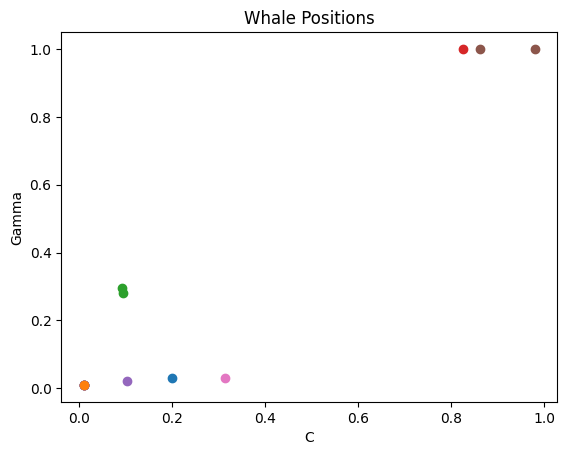

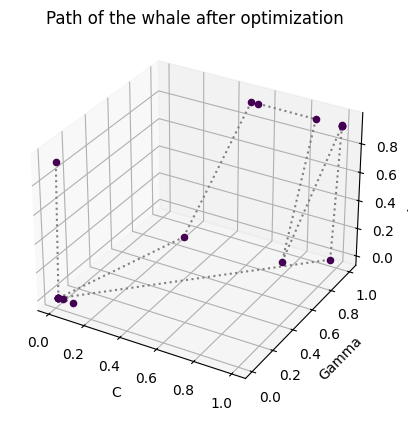

Best Position:  [0.11689810537097814, 0.018227319457369065, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
Best Position Info:  [14, 0, 4, 0.9574468085106383]
C value: 0.11689810537097814
C =  0.11689810537097814  Gamma =  0.018227319457369065
selected indices of best solution:  [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14]
Accuracy of the current Optimized Stacking Model:  0.948936170212766
kcv 2
op

Begin whale optimization algorithm on support vector machines




 K MEANS CLUSTERING 



Iter = 0 best fitness = 0.000
 C =  0.0  Gamma =  0.0
Feature Subset = [ 0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,]
whale 0 cluster 6 position: [[ 0.2580012779488161,0.9106487934085578,1,1,1,0,1,1,1,1,1,1,1,1,0,1,1,]] --> d_whale: [ 0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,]  ---> Accuracy: ( 0 )
whale 1 cluster 5 position: [[ 0.7243246320173747,0.23647459905774812,0,1,1,0,1,1,1,1,0,0,1,1,1,0,1,]] --> d_whale: [ 0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,

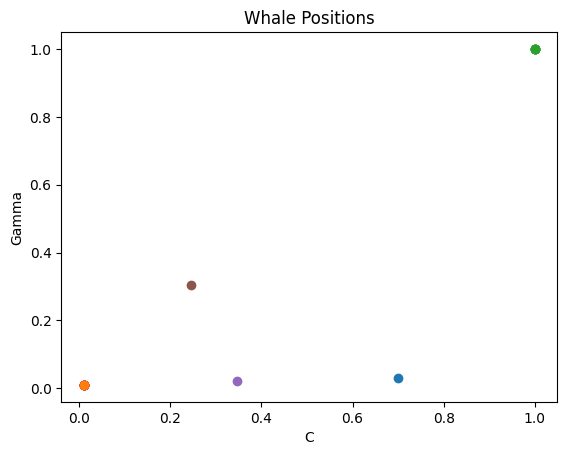

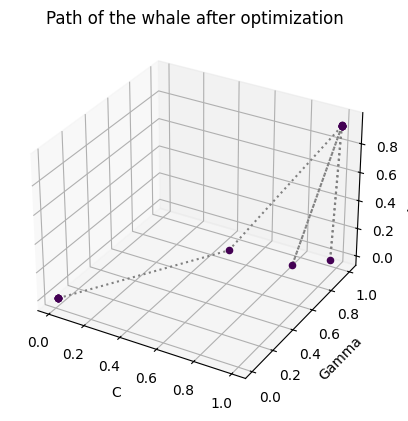

Best Position:  [0.02497441456751369, 0.02497441456751369, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
Best Position Info:  [5, 6, 19, 0.9531914893617022]
C value: 0.02497441456751369
C =  0.02497441456751369  Gamma =  0.02497441456751369
selected indices of best solution:  [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14]
Accuracy of the current Optimized Stacking Model:  0.9446808510638298
kcv 3
op

Begin whale optimization algorithm on support vector machines




 K MEANS CLUSTERING 



Iter = 0 best fitness = 0.000
 C =  0.0  Gamma =  0.0
Feature Subset = [ 0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,]
whale 0 cluster 6 position: [[ 0.2580012779488161,0.9106487934085578,1,1,1,0,1,1,1,1,1,1,1,1,0,1,1,]] --> d_whale: [ 0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,]  ---> Accuracy: ( 0 )
whale 1 cluster 5 position: [[ 0.7243246320173747,0.23647459905774812,0,1,1,0,1,1,1,1,0,0,1,1,1,0,1,]] --> d_whale: [ 0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0

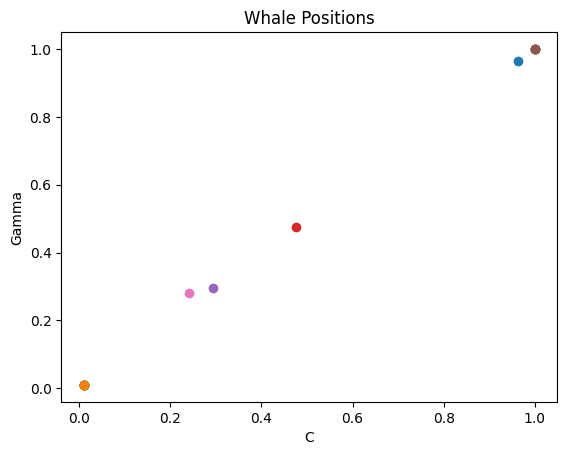

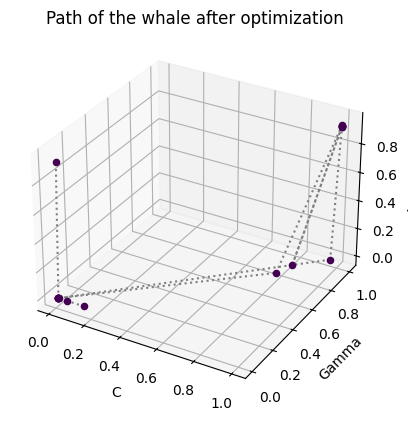

Best Position:  [0.030883426972121483, 0.030883426972121483, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
Best Position Info:  [3, 2, 15, 0.9574468085106383]
C value: 0.030883426972121483
C =  0.030883426972121483  Gamma =  0.030883426972121483
selected indices of best solution:  [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14]
Accuracy of the current Optimized Stacking Model:  0.9531914893617022
kcv 4
op

Begin whale optimization algorithm on support vector machines




 K MEANS CLUSTERING 



Iter = 0 best fitness = 0.000
 C =  0.0  Gamma =  0.0
Feature Subset = [ 0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,]
whale 0 cluster 6 position: [[ 0.2580012779488161,0.9106487934085578,1,1,1,0,1,1,1,1,1,1,1,1,0,1,1,]] --> d_whale: [ 0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,]  ---> Accuracy: ( 0 )
whale 1 cluster 5 position: [[ 0.7243246320173747,0.23647459905774812,0,1,1,0,1,1,1,1,0,0,1,1,1,0,1,]] --> d_whale: [ 0.0,0.0,0.0,0.0,0.0,0.0,0.0,

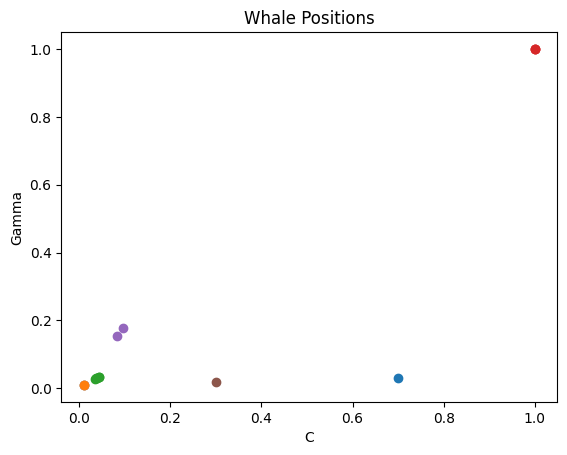

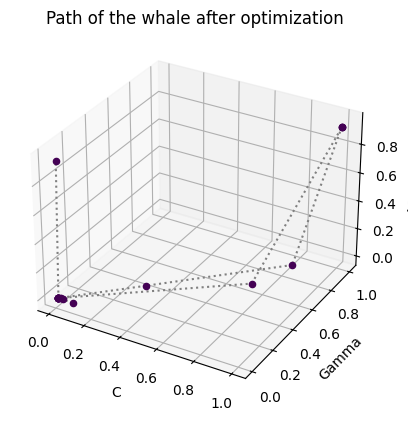

Best Position:  [0.6984015041040207, 0.6232456290508526, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
Best Position Info:  [10, 1, 1, 0.9531914893617022]
C value: 0.6984015041040207
C =  0.6984015041040207  Gamma =  0.6232456290508526
selected indices of best solution:  [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14]
Accuracy of the current Optimized Stacking Model:  0.9404255319148936
kcv 5
op

Begin whale optimization algorithm on support vector machines




 K MEANS CLUSTERING 



Iter = 0 best fitness = 0.000
 C =  0.0  Gamma =  0.0
Feature Subset = [ 0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,]
whale 0 cluster 6 position: [[ 0.2580012779488161,0.9106487934085578,1,1,1,0,1,1,1,1,1,1,1,1,0,1,1,]] --> d_whale: [ 0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,]  ---> Accuracy: ( 0 )
whale 1 cluster 5 position: [[ 0.7243246320173747,0.23647459905774812,0,1,1,0,1,1,1,1,0,0,1,1,1,0,1,]] --> d_whale: [ 0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.

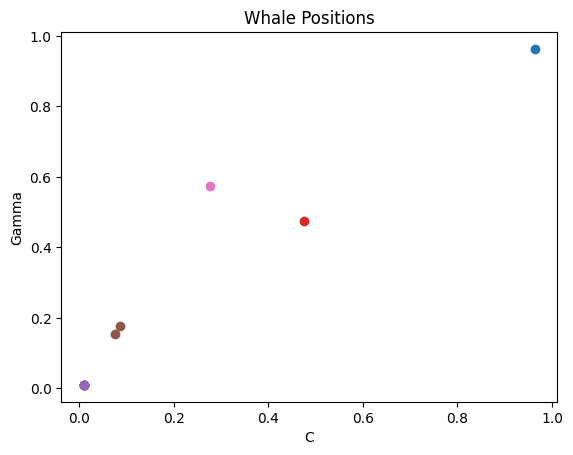

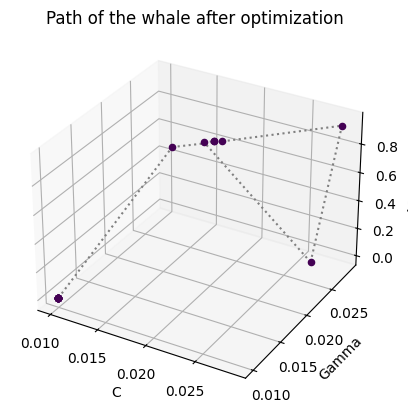

Best Position:  [0.033514192605322304, 0.033514192605322304, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
Best Position Info:  [1, 5, 3, 0.9531914893617022]
C value: 0.033514192605322304
C =  0.033514192605322304  Gamma =  0.033514192605322304
selected indices of best solution:  [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14]
Accuracy of the current Optimized Stacking Model:  0.9531914893617022
kcv 6
op

Begin whale optimization algorithm on support vector machines




 K MEANS CLUSTERING 



Iter = 0 best fitness = 0.000
 C =  0.0  Gamma =  0.0
Feature Subset = [ 0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,]
whale 0 cluster 6 position: [[ 0.2580012779488161,0.9106487934085578,1,1,1,0,1,1,1,1,1,1,1,1,0,1,1,]] --> d_whale: [ 0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,]  ---> Accuracy: ( 0 )
whale 1 cluster 5 position: [[ 0.7243246320173747,0.23647459905774812,0,1,1,0,1,1,1,1,0,0,1,1,1,0,1,]] --> d_whale: [ 0.0,0.0,0.0,0.0,0.0,0.0,0.0,0

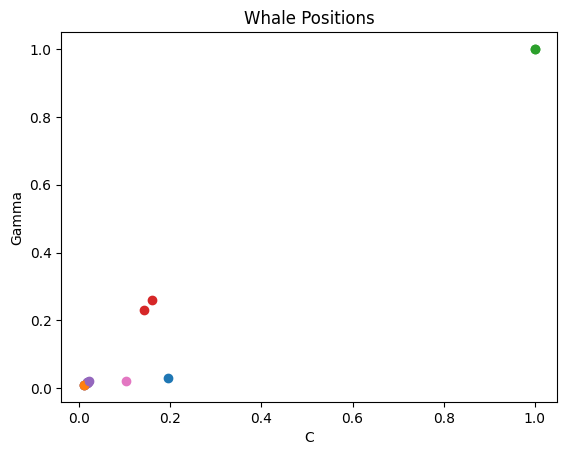

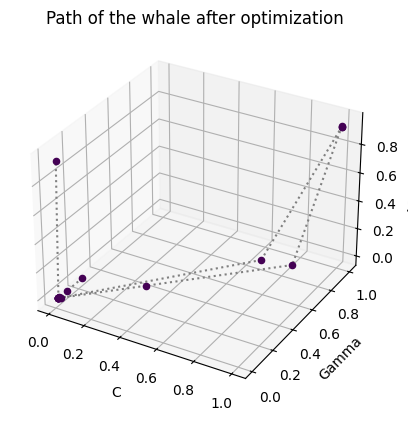

Best Position:  [0.10155992050796316, 0.020596510225705054, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
Best Position Info:  [14, 6, 11, 0.9531914893617022]
C value: 0.10155992050796316
C =  0.10155992050796316  Gamma =  0.020596510225705054
selected indices of best solution:  [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14]
Accuracy of the current Optimized Stacking Model:  0.948936170212766
kcv 7
op

Begin whale optimization algorithm on support vector machines




 K MEANS CLUSTERING 



Iter = 0 best fitness = 0.000
 C =  0.0  Gamma =  0.0
Feature Subset = [ 0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,]
whale 0 cluster 6 position: [[ 0.2580012779488161,0.9106487934085578,1,1,1,0,1,1,1,1,1,1,1,1,0,1,1,]] --> d_whale: [ 0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,]  ---> Accuracy: ( 0 )
whale 1 cluster 5 position: [[ 0.7243246320173747,0.23647459905774812,0,1,1,0,1,1,1,1,0,0,1,1,1,0,1,]] --> d_whale: [ 0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0

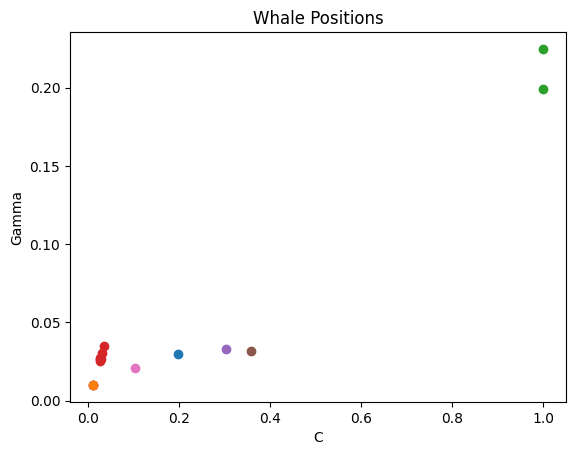

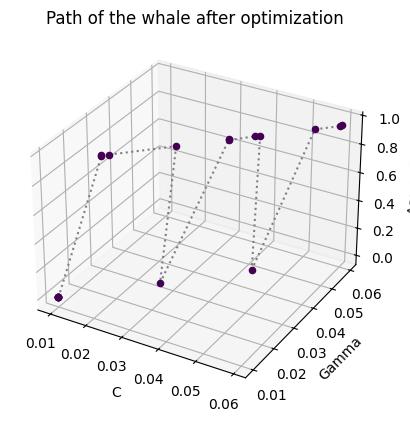

Best Position:  [0.049203935021736186, 0.04919981177931135, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
Best Position Info:  [6, 3, 14, 0.9574468085106383]
C value: 0.049203935021736186
C =  0.049203935021736186  Gamma =  0.04919981177931135
selected indices of best solution:  [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14]
Accuracy of the current Optimized Stacking Model:  0.9446808510638298
kcv 8
op

Begin whale optimization algorithm on support vector machines




 K MEANS CLUSTERING 



Iter = 0 best fitness = 0.000
 C =  0.0  Gamma =  0.0
Feature Subset = [ 0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,]
whale 0 cluster 6 position: [[ 0.2580012779488161,0.9106487934085578,1,1,1,0,1,1,1,1,1,1,1,1,0,1,1,]] --> d_whale: [ 0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,]  ---> Accuracy: ( 0 )
whale 1 cluster 5 position: [[ 0.7243246320173747,0.23647459905774812,0,1,1,0,1,1,1,1,0,0,1,1,1,0,1,]] --> d_whale: [ 0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.

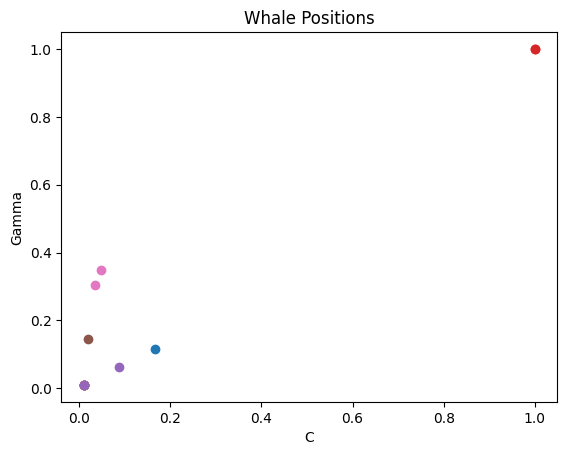

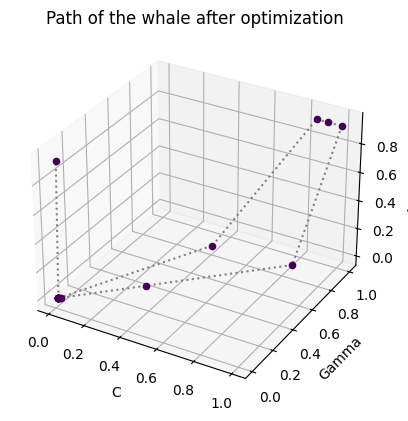

Best Position:  [0.013087922490197013, 0.6463233293659147, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
Best Position Info:  [7, 4, 5, 0.9574468085106383]
C value: 0.013087922490197013
C =  0.013087922490197013  Gamma =  0.6463233293659147
selected indices of best solution:  [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14]
Accuracy of the current Optimized Stacking Model:  0.9446808510638298
kcv 9
op

Begin whale optimization algorithm on support vector machines




 K MEANS CLUSTERING 



Iter = 0 best fitness = 0.000
 C =  0.0  Gamma =  0.0
Feature Subset = [ 0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,]
whale 0 cluster 6 position: [[ 0.2580012779488161,0.9106487934085578,1,1,1,0,1,1,1,1,1,1,1,1,0,1,1,]] --> d_whale: [ 0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,]  ---> Accuracy: ( 0 )
whale 1 cluster 5 position: [[ 0.7243246320173747,0.23647459905774812,0,1,1,0,1,1,1,1,0,0,1,1,1,0,1,]] --> d_whale: [ 0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0

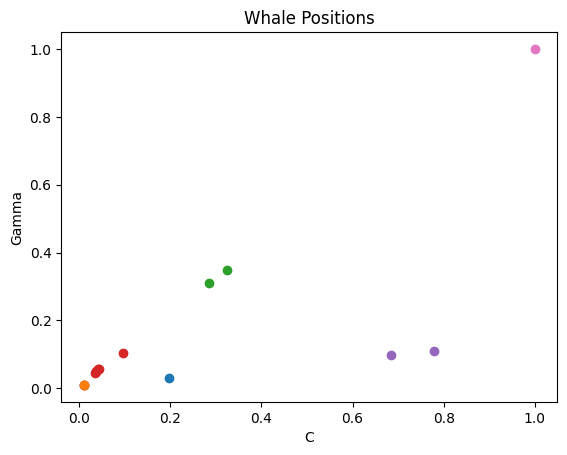

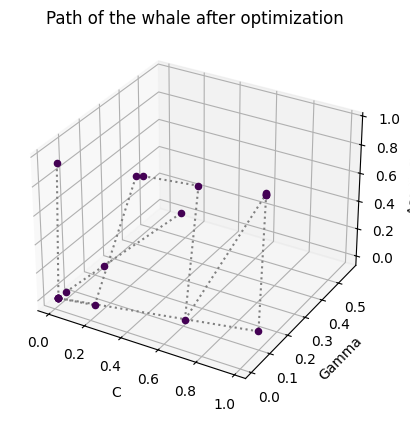

Best Position:  [0.11390181359470135, 0.015606799283238191, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
Best Position Info:  [8, 0, 5, 0.9531914893617022]
C value: 0.11390181359470135
C =  0.11390181359470135  Gamma =  0.015606799283238191
selected indices of best solution:  [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14]
Accuracy of the current Optimized Stacking Model:  0.948936170212766
Accuracy list:  [0.9404255319148936, 0.948936170212766, 0.9446808510638298, 0.9531914893617022, 0.9404255319148936, 0.9531914893617022, 0.948936170212766, 0.9446808510638298, 0.9446808510638298, 0.948936170212766]
Accuracy after 10 fold cv:  0.946808510638298


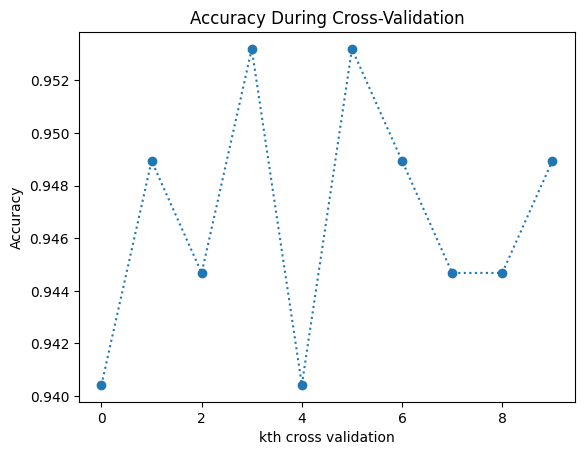

0.946808510638298


In [ ]:
k_cv = 10
kcv_acc = k_fold_cv(k_cv)
print(kcv_acc)

In [ ]:
from sklearn.ensemble import ExtraTreesClassifier, VotingClassifier
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score

# Define kernel type
kernel = 'rbf'  # Choose between 'rbf' or 'linear'

# Define models
if kernel == 'rbf':
    svm_model = SVC(kernel='rbf', C=1.0, gamma=1.0, probability=True)  # Use `probability=True` for ensemble
else:
    svm_model = SVC(kernel='linear', probability=True)

extra_trees_model = ExtraTreesClassifier(n_estimators=100, random_state=42)

# Combine SVM and Extra Trees in a Voting Classifier
ensemble_model = VotingClassifier(
    estimators=[
        ('svm', svm_model),
        ('extra_trees', extra_trees_model)
    ],
    voting='soft'  # Use 'soft' voting for probabilities
)

# Train the ensemble model
ensemble_model.fit(x_train, y_train)

# Predict and calculate accuracy
ensemble_y_pred = ensemble_model.predict(x_test)
ensemble_score = accuracy_score(ensemble_y_pred, y_test)

print("Accuracy of the Ensemble: ", ensemble_score)


Accuracy of the SVM + Extra Trees Ensemble:  0.9361702127659575


In [ ]:
if(kcv_acc > ensemble_score):
  print("IMPROVED ==> ",end=" ")
  print("optimized score: ",kcv_acc," normal score: ",ensemble_score)
elif(kcv_acc == ensemble_score):
    print("NOT AFFECTED")
else:
  print("TRY AGAIN")

IMPROVED ==>  optimized score:  0.946808510638298  normal score:  0.9361702127659575
